#### Consider the nonlinear Schrödinger equation with natural boundary conditions: $u_{x}(x_L,t) = u_{x}(x_R,t) = 0$ for all $t$


\begin{align}\label{Schrodinger_eqn}
    i u_t + u_{xx} + q |u|^2 u & = 0, \text{on} \ [x_L,x_R] \times (0,T], \\
    u(x,0) = \textrm{sech}(x).
\end{align}
#### Consider the FEM semi-discretization  in space
\begin{align}\label{ODE_system_FEM}
    \dot{U}(t) = -\left[\frac{1}{h^2} \tilde{I}^{-1}SU(t) + \beta F(U)\right] :=f_{\textrm{FEM}}.
\end{align}

#### This code will compute the time derivative of the discrete analogues of the invariants

\begin{align}
    N(t)&:=\int_{\mathbb{R}} |u(x,t)|^2 dx \equiv N(0),\\
    E(t)&:=\int_{\mathbb{R}}  \left( |u_x(x,t)|^2 - \frac{\beta}{2}|u(x,t)|^4\right) dx \equiv E(0) \;,
\end{align}

#### for the finite element semi-discretization and generate Figure 6 in the manuscript. 

#### Select sol = 2 and 3 for the plots corresponding to the 2-soliton and 3-soliton solutions, respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sol = 2 # choose here to change for 2-soliton or 3-soliton solution
# Different cases
if sol == 2: 
    q = 8; xL = -35; xR = 35; L = xR-xL; m1 = 12   
elif sol == 3: 
    q = 18; xL = -35; xR = 35; L = xR-xL; m1 = 16

In [3]:
# Domain = [x_L,x_R]
dx = 1./m1; m = int((xR-xL)/dx); x = np.linspace(xL,xR,m); dx = x[1] - x[0]

# The matrix I_tilde
It = np.eye(2*m)
It[0][0] = 0.5; It[1][1] = 0.5
It[-1][-1] = 0.5; It[-2][-2] = 0.5
Itinv = np.diag(1./np.diag(It))

# The matrix S
A = np.array([[0, 1.], [-1., 0]])
S = np.zeros((2*m,2*m))
for j in range(1,m-1):
    S[2*j:2*j+2,2*j:2*j+2] = -2*A[:,:]
    S[2*j:2*j+2,2*j+2:2*j+4] = A[:,:]
    S[2*j:2*j+2,2*j-2:2*j] = A[:,:]
    
S[:2,:2] = -A[:,:]  # Look at these to understand the indices of matrix
S[-2:,-2:] = -A[:,:]

S[:2,2:4] = A
S[-2:,-4:-2] = A # Look at these to understand the indices of matrix

ItinvS = np.dot(Itinv,S) # I_tilde^(-1)*S

I = np.eye(2*m)
M = -1./dx**2 * ItinvS

In [4]:
# Required functions
def rhs_stiff(U,dx):  # The stiff part of the right hand side of the system of ODEs: du/dt = rhs
    ret = -1./dx**2 * np.dot(ItinvS,U) 
    return ret

# Vectorized nonlinear term: non-stiff part
I1 = np.eye(m)
I2 = np.array([[1,1.],[1,1]])
A1 = np.kron(I1,A)
A2 = np.kron(I1,I2)

def rhs_non_stiff(U,q):  # The non-stiff part of the right hand side of the system of ODEs: du/dt = rhs
    ret = -q*np.multiply(np.dot(A1,U),np.dot(A2,np.square(U)))
    return ret

def eta1(U,dx):  # Entropy: first quantity
    V = U[::2]
    W = U[1::2]
    return dx*np.sum(V**2+W**2)

def eta2(U,dx,q):   # Entropy: second quantity
    V = U[::2]
    W = U[1::2]
    return np.sum((np.diff(V)**2+np.diff(W)**2)/dx - 0.5*q*dx*(V[:-1]**2+W[:-1]**2)**2)


def NLS_True_Sol(t,x,q):
    if q == 1:
        a = 1; c = 3; x0 = -10; theta0 = np.pi/4 
        ut = np.zeros(len(x))
        for i, xp in enumerate(x):
            ut[i] = np.sqrt(2)*np.exp(1j*((3/2)*(xp-c*t-x0)+theta0))*np.exp(1j*(a+c**2/4)*t) \
            /np.cosh(xp-c*t-x0)  
    elif q == 2:
        ut = np.exp(1j*t)/np.cosh(x)
    elif q == 8:
        sechx = 1./np.cosh(x)
        ut = np.exp(1j*t)*sechx*( 1+(3/4)*sechx**2*(np.exp(8*1j*t)-1) )/( 1-(3/4)*sechx**4*np.sin(4*t)**2 )
    elif q == 18:
        ut = (2*(3*np.exp(t*25*1j)*np.exp(x) + 15*np.exp(t*9*1j)*np.exp(9*x) + 48*np.exp(t*25*1j)*np.exp(7*x) + 48*np.exp(t*25*1j)*np.exp(11*x) + 24*np.exp(t*33*1j)*np.exp(3*x) + 54*np.exp(t*33*1j)*np.exp(5*x) + 3*np.exp(t*25*1j)*np.exp(17*x) + 54*np.exp(t*33*1j)*np.exp(13*x) + 24*np.exp(t*33*1j)*np.exp(15*x) + 135*np.exp(t*41*1j)*np.exp(9*x) + 30*np.exp(t*49*1j)*np.exp(5*x) + 120*np.exp(t*49*1j)*np.exp(7*x) + 120*np.exp(t*49*1j)*np.exp(11*x) + 30*np.exp(t*49*1j)*np.exp(13*x) + 60*np.exp(t*57*1j)*np.exp(9*x)))/(3*(np.exp(t*24*1j) + 10*np.exp(6*x) + 10*np.exp(12*x) + 45*np.exp(t*8*1j)*np.exp(8*x) + 45*np.exp(t*8*1j)*np.exp(10*x) + 18*np.exp(t*16*1j)*np.exp(4*x) + 9*np.exp(t*24*1j)*np.exp(2*x) + 18*np.exp(t*16*1j)*np.exp(14*x) + 64*np.exp(t*24*1j)*np.exp(6*x) + 36*np.exp(t*24*1j)*np.exp(8*x) + 36*np.exp(t*24*1j)*np.exp(10*x) + 64*np.exp(t*24*1j)*np.exp(12*x) + 18*np.exp(t*32*1j)*np.exp(4*x) + 9*np.exp(t*24*1j)*np.exp(16*x) + np.exp(t*24*1j)*np.exp(18*x) + 18*np.exp(t*32*1j)*np.exp(14*x) + 45*np.exp(t*40*1j)*np.exp(8*x) + 45*np.exp(t*40*1j)*np.exp(10*x) + 10*np.exp(t*48*1j)*np.exp(6*x) + 10*np.exp(t*48*1j)*np.exp(12*x)))  
    
    V = ut.real; W = ut.imag
    u = np.zeros((2*len(x)))
    u[::2] = V; u[1::2] = W  
    return u

In [5]:
def grad_eta1(u,dx):
    return 2*dx*u

def grad_eta2(u,dx,q):
    term1 = (2/dx)*(-1*np.roll(u,2) + 2*u -1*np.roll(u,-2))
    V = u[::2]; W = u[1::2]; abs2_u = V**2+W**2; rep2_abs2_u = np.repeat(abs2_u,2)
    term2 = (2*dx*q)*np.multiply(rep2_abs2_u ,u)
    return term1-term2

def t_deriv_eta1(u,dx):
    f = rhs_stiff(u,dx)+rhs_non_stiff(u,q)
    grad1 = grad_eta1(u,dx)
    return np.dot(grad1,f)

def t_deriv_eta2(u,dx,q):
    f = rhs_stiff(u,dx)+rhs_non_stiff(u,q)
    grad2 = grad_eta2(u,dx,q)
    return np.dot(grad2,f)

In [6]:
T = np.linspace(0,20,20); Z1 = []; Z2 = []
for i in range(len(T)):
    u = NLS_True_Sol(T[i],x,q) 
    temp1 = t_deriv_eta1(u,dx); temp2 = t_deriv_eta2(u,dx,q) 
    Z1 = np.append(Z1,temp1) ;Z2 = np.append(Z2,temp2)   

In [7]:
import os
path = './Figures/'
if not os.path.exists(path):
   os.makedirs(path)

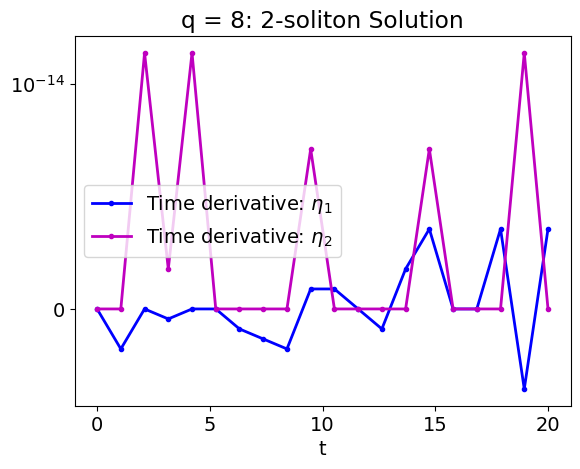

In [8]:
font = {#'family' : 'normal',
'weight' : 'normal',
'size'   : 14}
plt.rc('font', **font)

plt.plot(T,Z1,'.-b',label = 'Time derivative: $\eta_1$',linewidth=2)
plt.plot(T,Z2,'.-m',label = 'Time derivative: $\eta_2$',linewidth=2)
plt.yscale("symlog", linthresh=1.e-14)
plt.title('q = %d: %d-soliton Solution'%(q,sol))
plt.xlabel('t')
plt.yscale("symlog", linthresh=1.e-14)
plt.legend()
#plt.show()
#plt.ylim(-1e-16, 1e-16)

plt.savefig('./Figures/FEM_Semi_Dis_Time_Derivative_%d_Soliton_Sol.pdf'%(sol),format='pdf', bbox_inches="tight",transparent=True)
